In [2]:
import ast
import os
import pickle as pkl
from collections import defaultdict
from plot_utils import (
    plot_heatmap,
)
from data_utils import (
    read_files,
    results2df,
    calculate_all_metrics,
    return_ct_location_segments,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torchmetrics.functional.classification import (
    multilabel_average_precision,
)

plt.style.use("science")

**Load annotations and results**

In [5]:
# model name
model_name = "slow_r50-w-negatives"
folder_path = "../dataset/results/"
metadata_file = "../dataset/metadata/metadata.csv"
behavioural_labels_file = "../dataset/metadata/behaviours.txt"
segements_file = "../dataset/metadata/segments.txt"


# list all result files in the folder which end with .pkl and contain the model name
result_info = {}

for file in os.listdir(folder_path):
    if file.endswith(".pkl") and model_name in file:

        if "-kinetics" not in file:
            epoch = file.split("_")[-2].split("=")[1]
        else:
            epoch = file.split("_")[-2].split("=")[1].split("-")[0]

        # get the split from the file name
        split = file.split("=")[-1].split(".")[0]

        # add model to the dictionary
        if model_name not in result_info:
            result_info[model_name] = {}
        # add epoch to the dictionary
        if epoch not in result_info[model_name]:
            result_info[model_name][epoch] = {}
        if split not in result_info[model_name][epoch]:
            result_info[model_name][epoch][split] = {}
        result_info[model_name][epoch][split] = {
            "file_path": os.path.join(folder_path, file),
        }

In [6]:
metadata_df = pd.read_csv(metadata_file)

with open(behavioural_labels_file, "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

with open(segements_file, "rb") as f:
    segments = [seg.decode("utf-8").strip() for seg in f.readlines()]

# build dict for behavioural where key is the segment and value is the behaviour is the same index
behavioural_dict = {}
for i, (b, s) in enumerate(zip(behaviours, segments)):
    if s not in behavioural_dict:
        behavioural_dict[s] = []
    behavioural_dict[s].append(b)

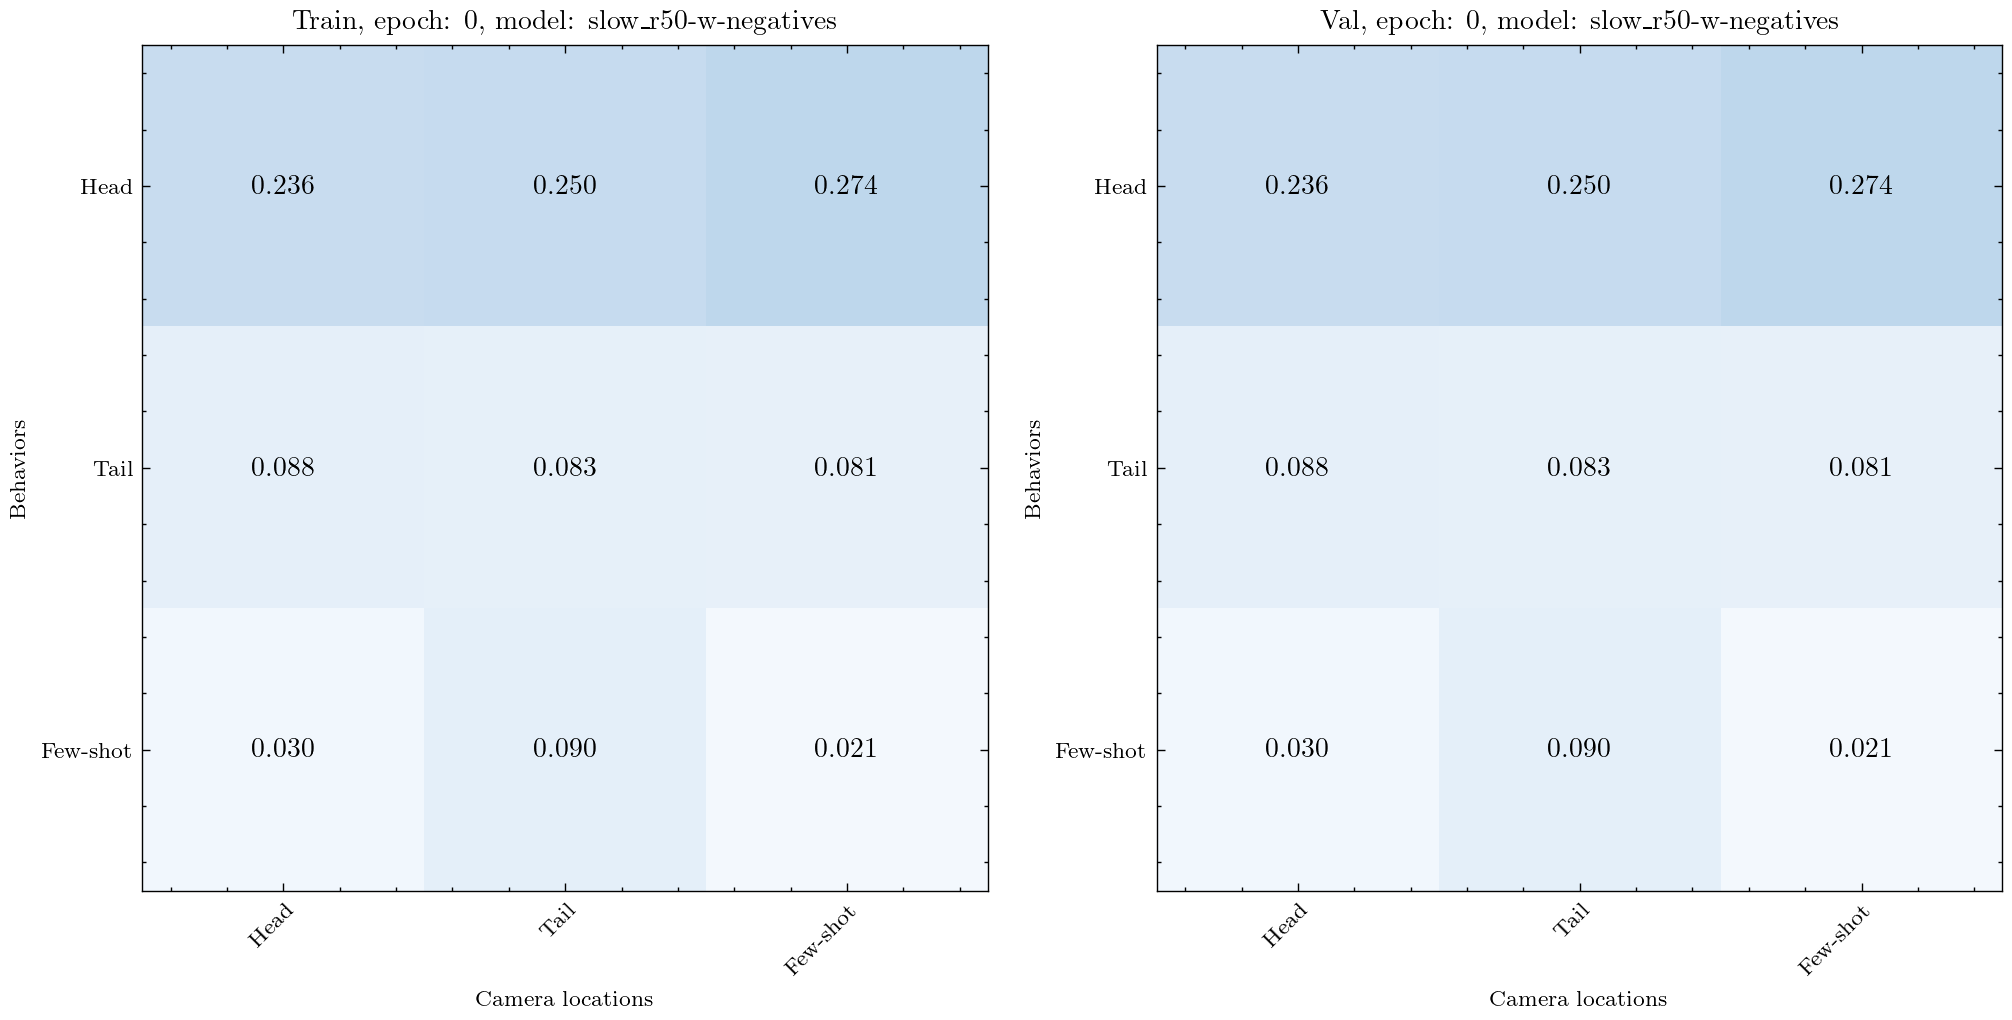

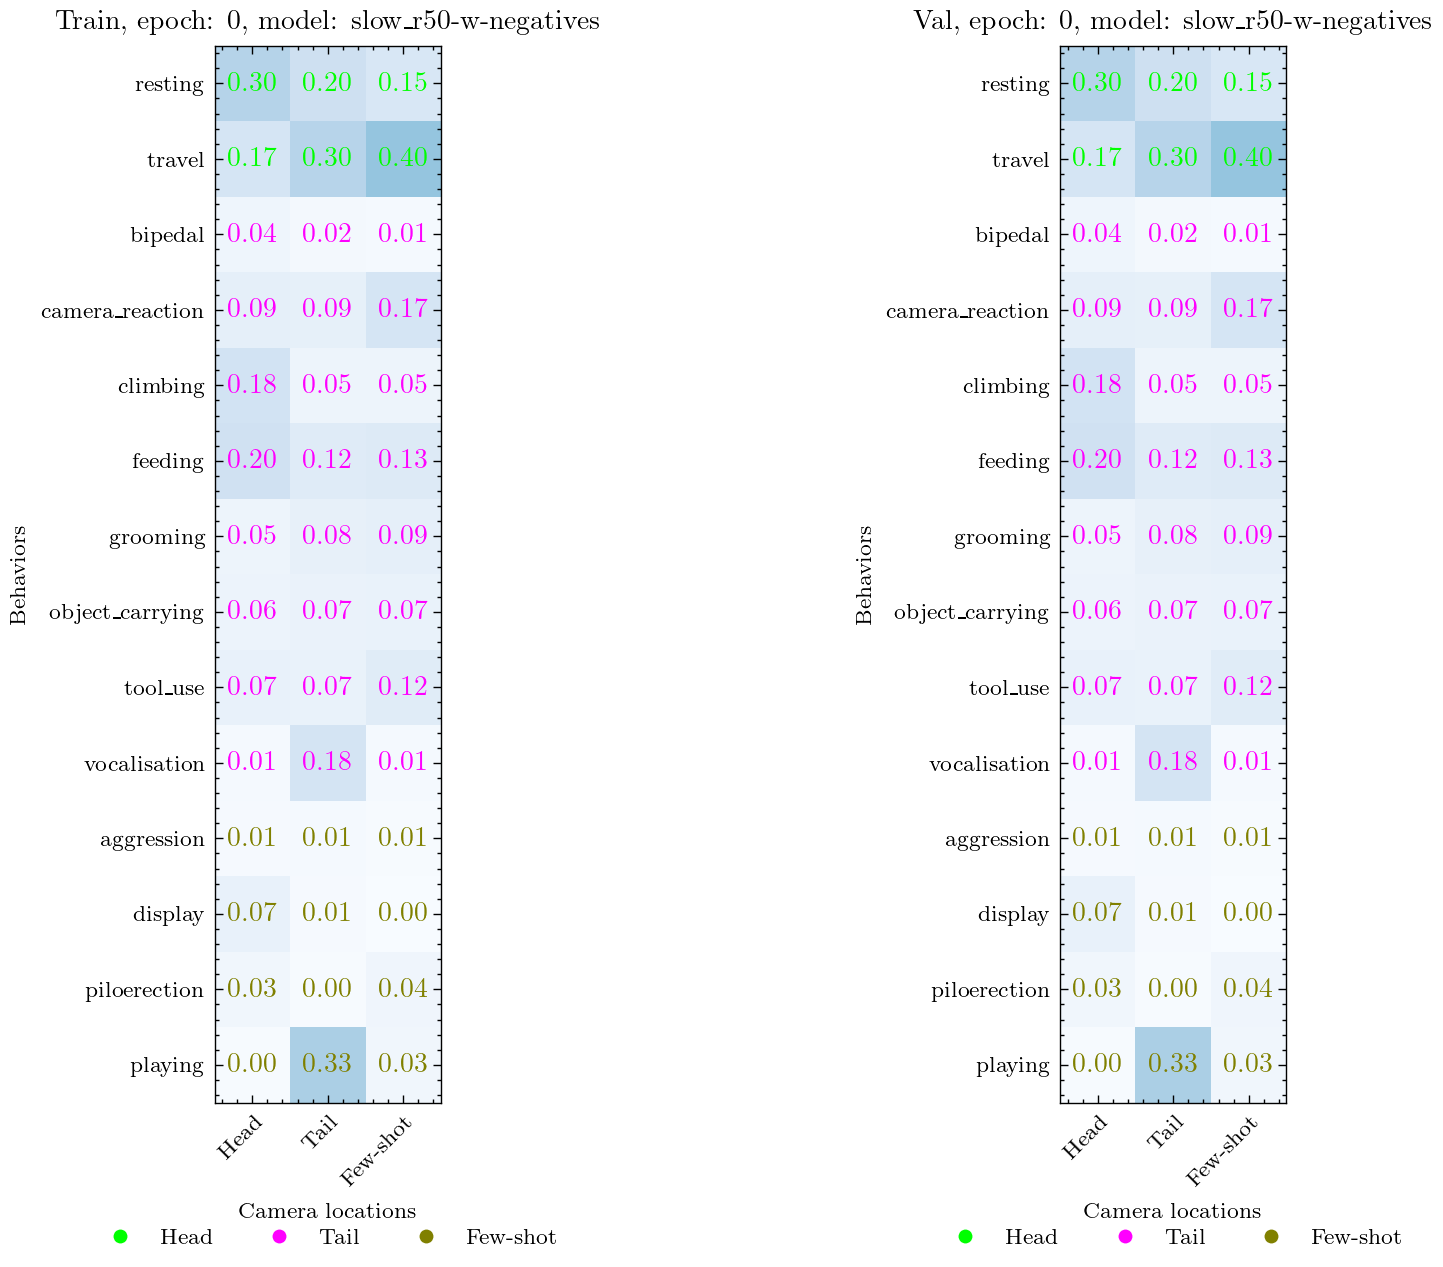

/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028


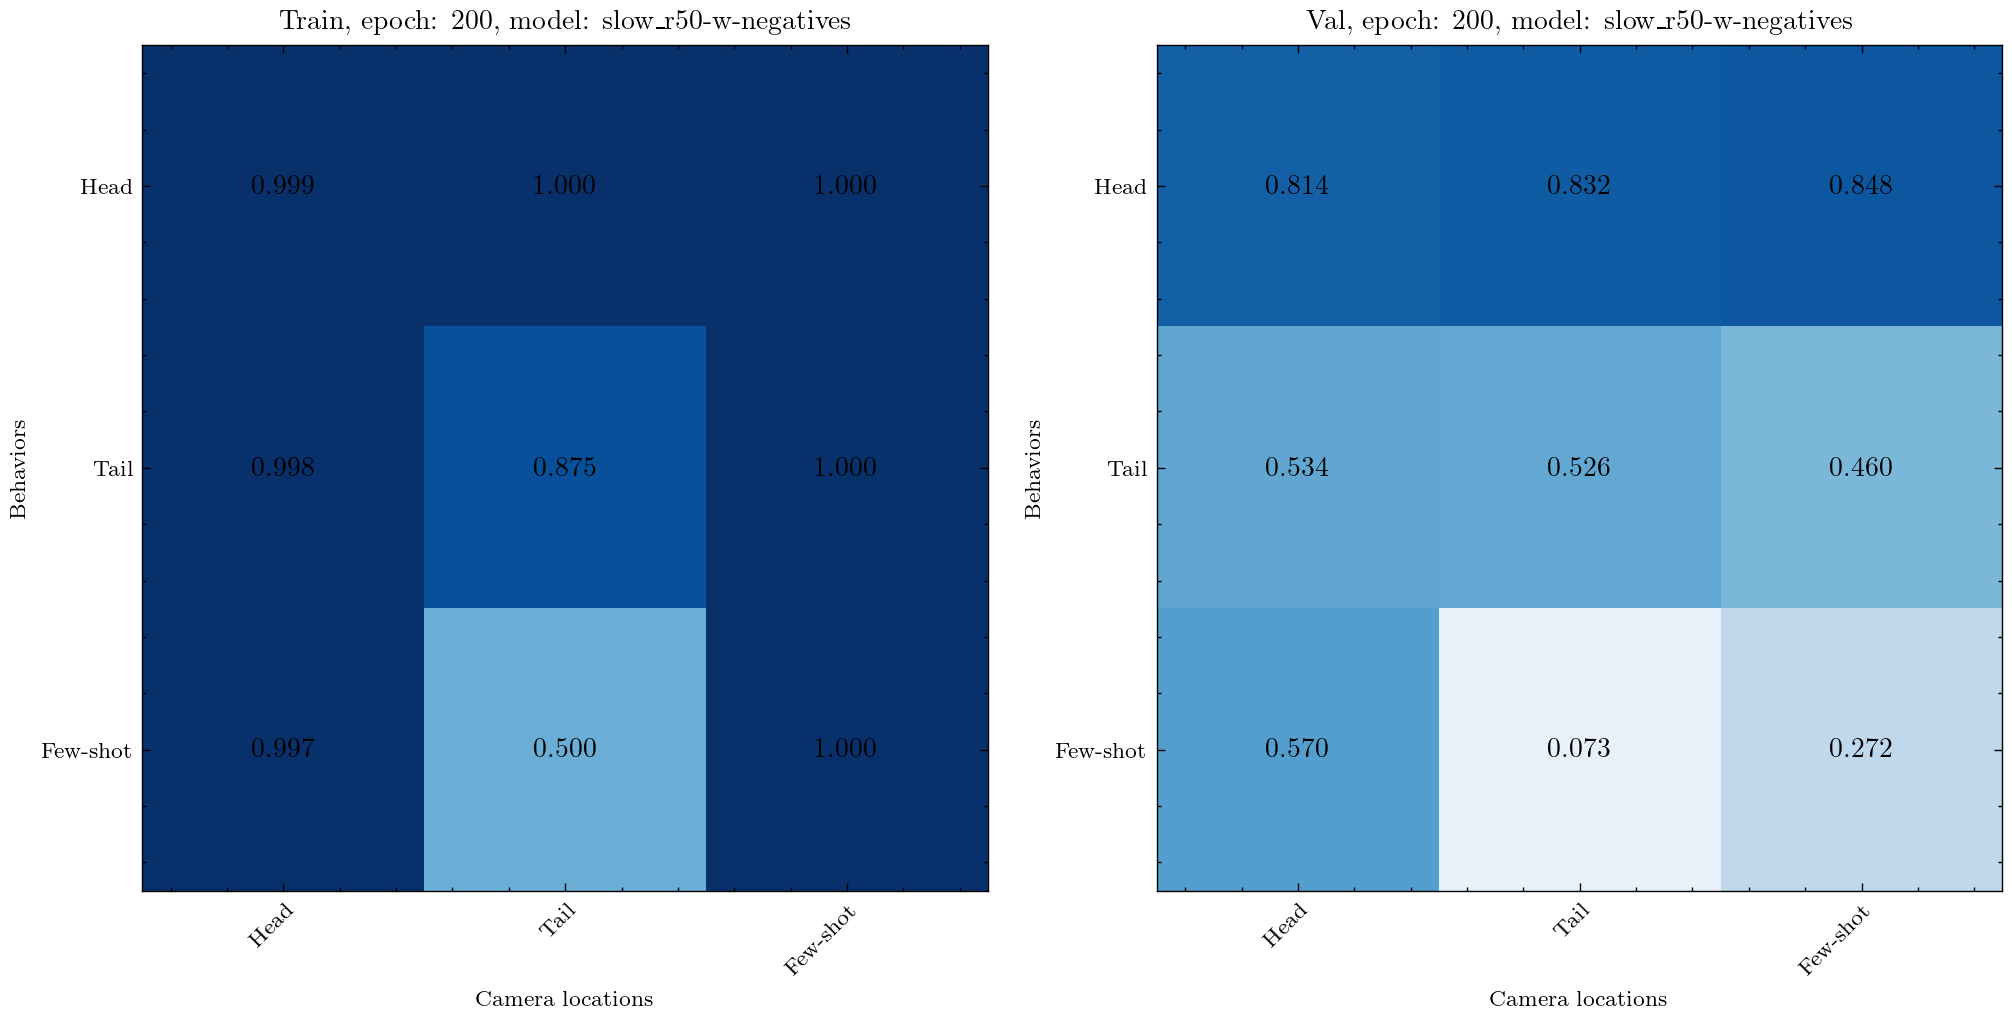

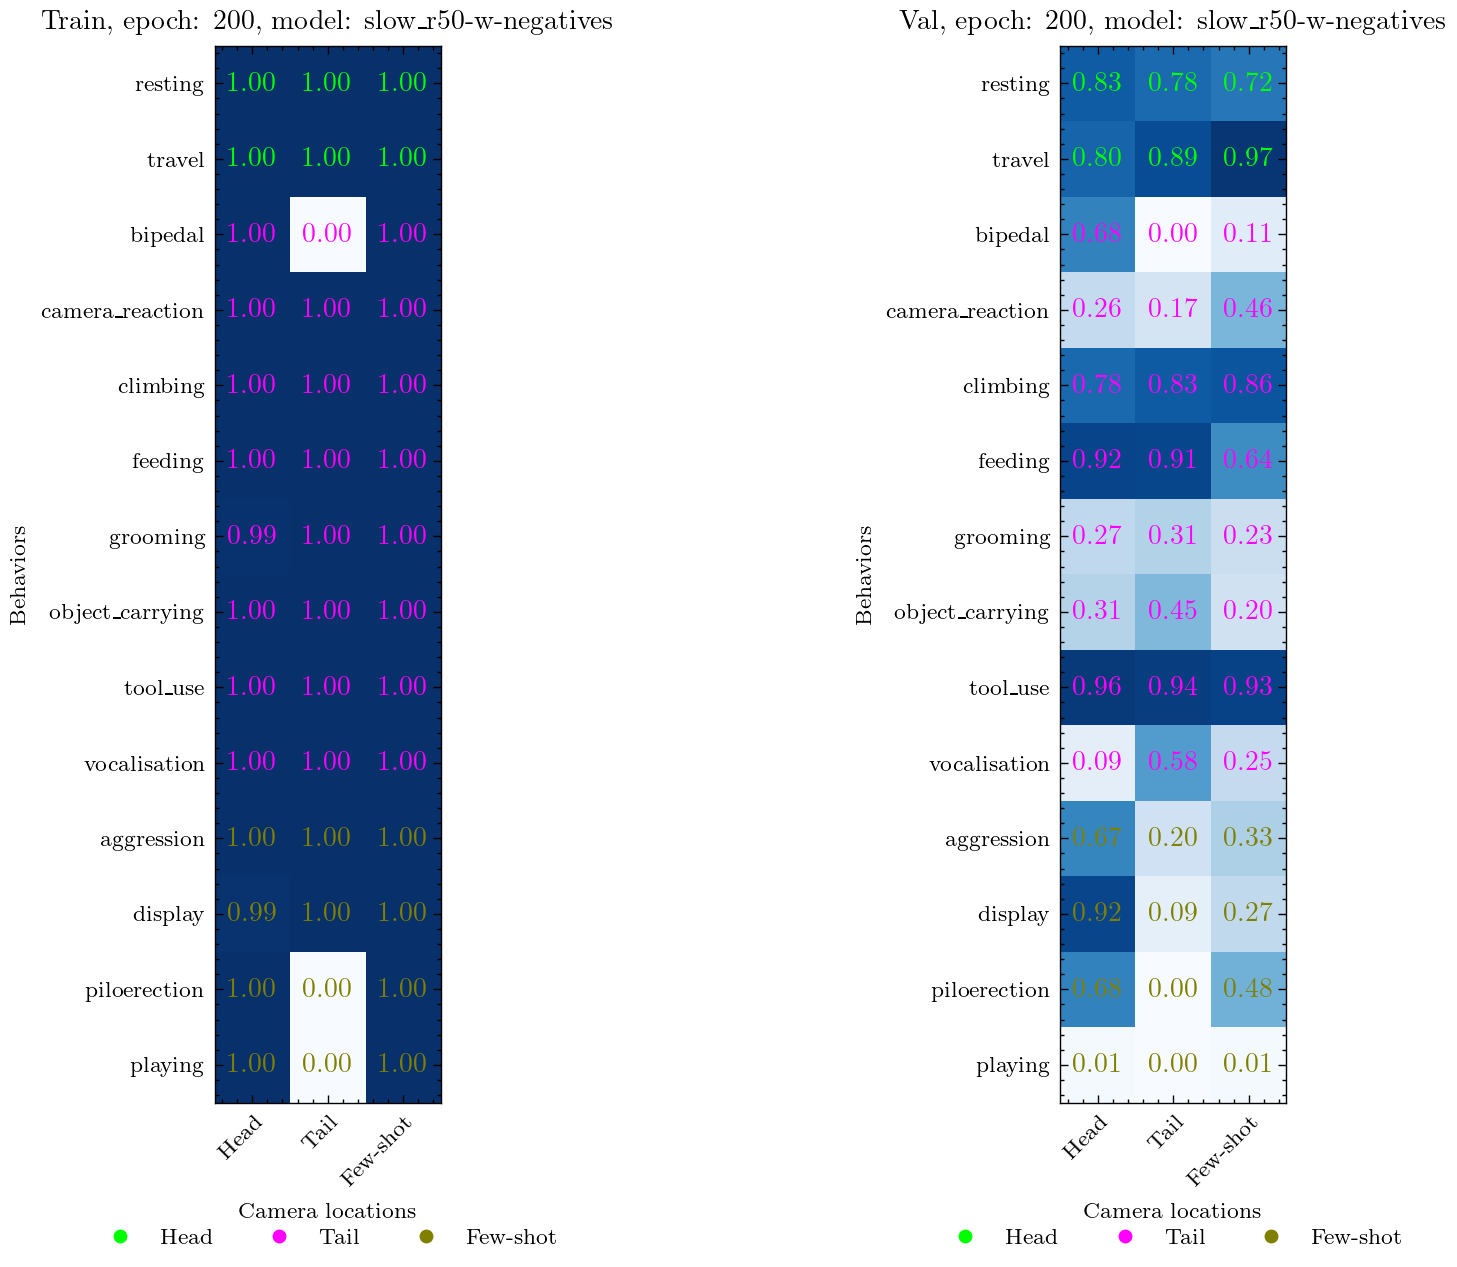

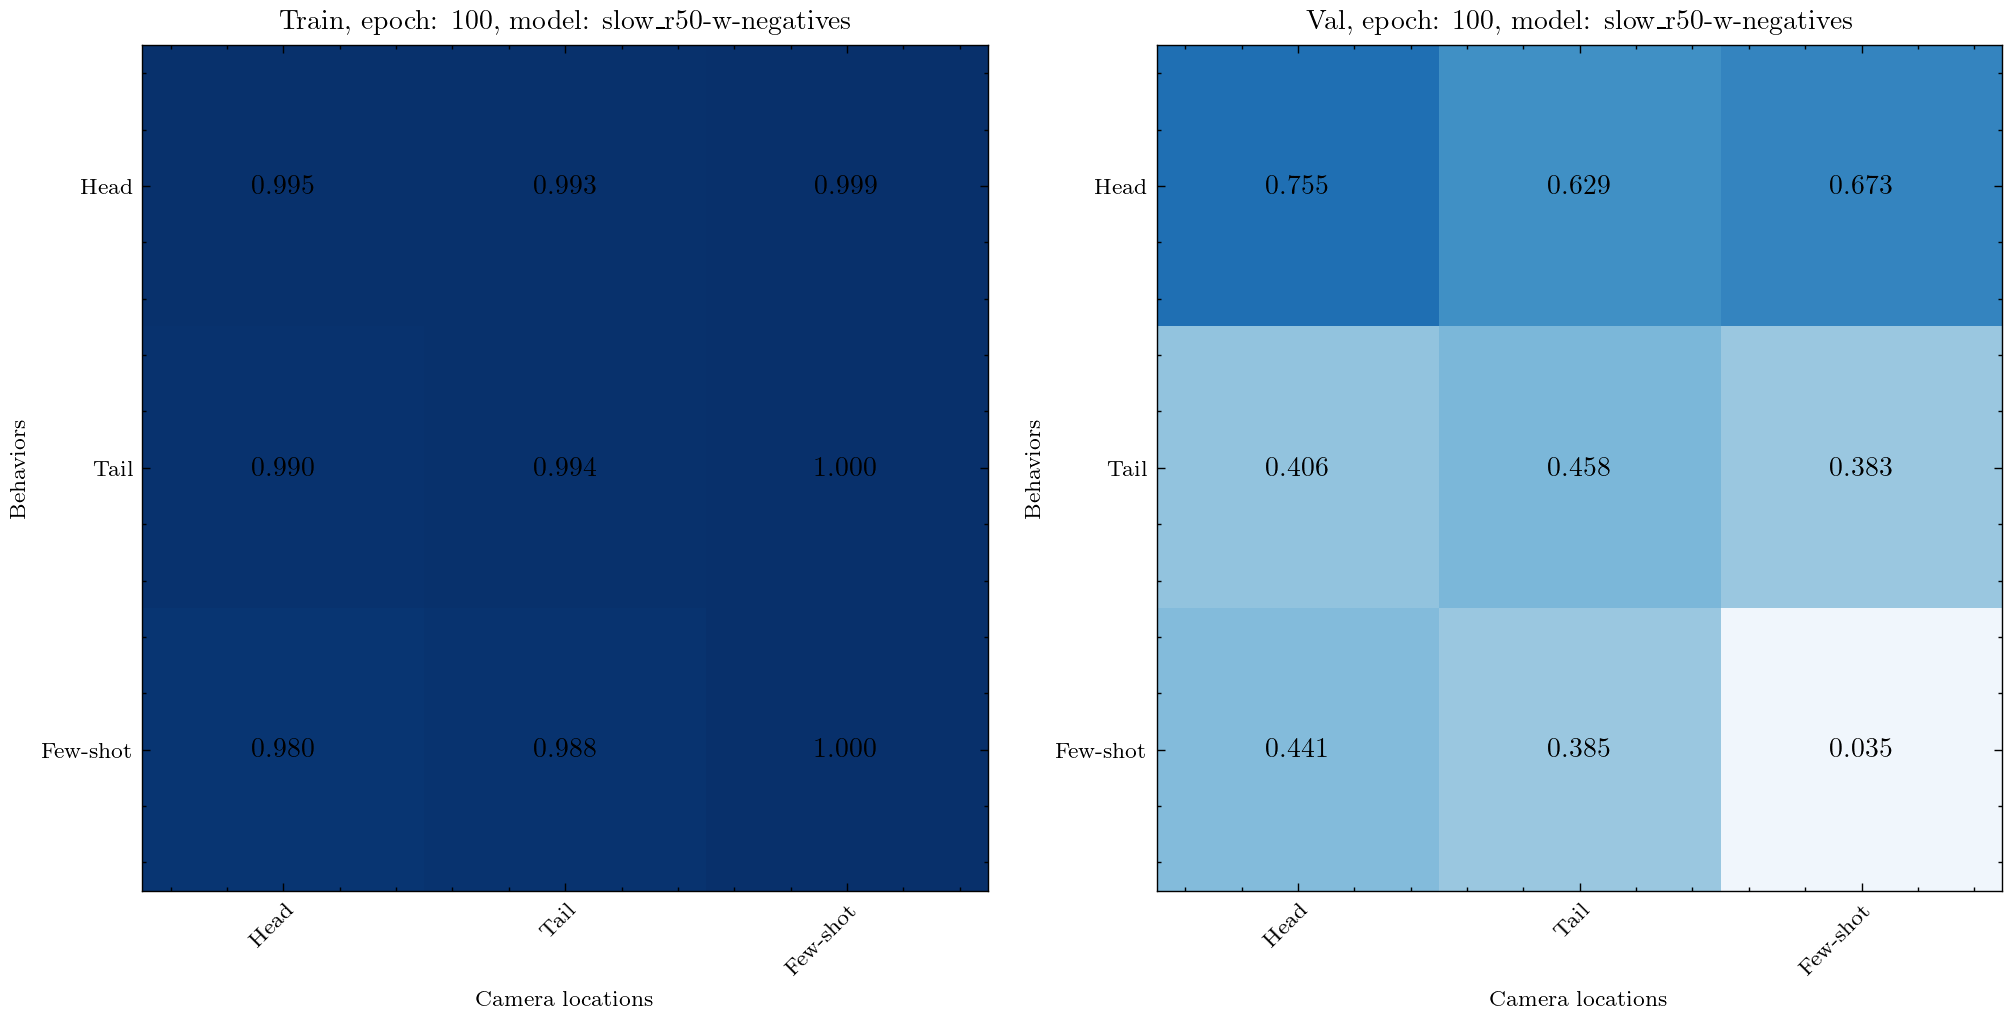

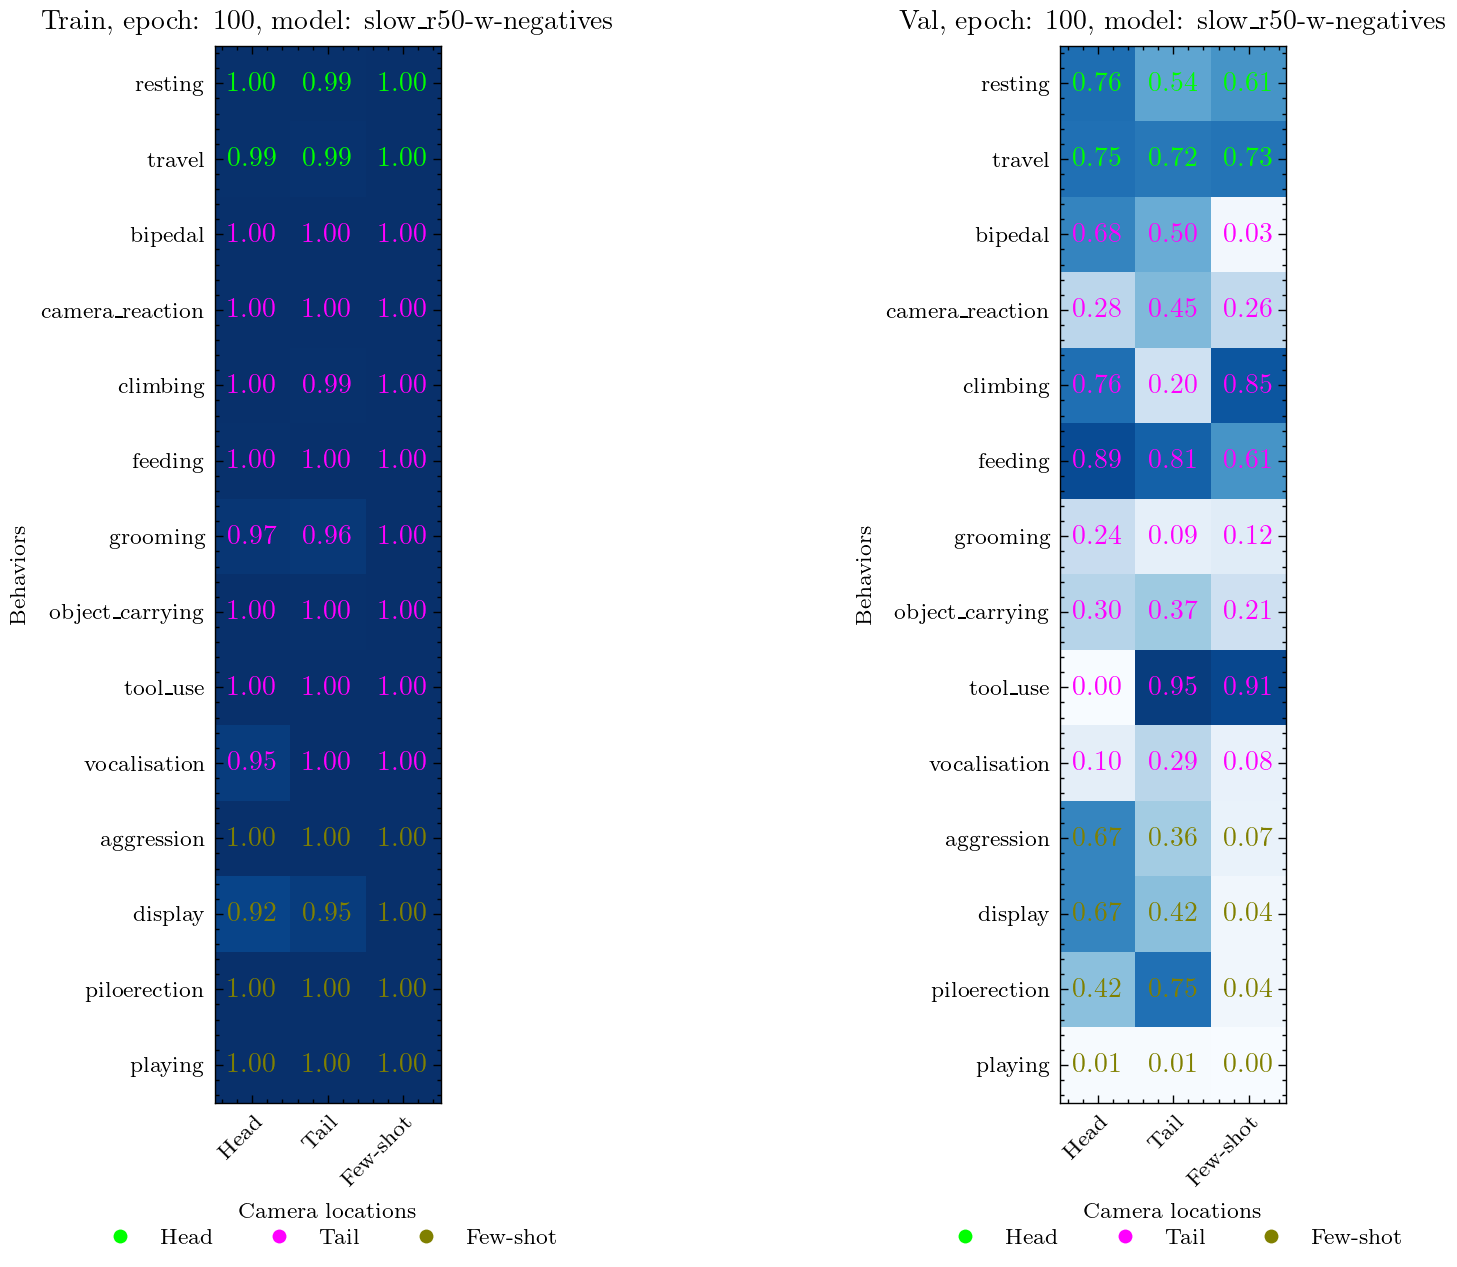

In [12]:
labels = ["Head", "Tail", "Few-shot"]
reordered_behaviours = [
    "resting",
    "travel",
    "bipedal",
    "camera_reaction",
    "climbing",
    "feeding",
    "grooming",
    "object_carrying",
    "tool_use",
    "vocalisation",
    "aggression",
    "display",
    "piloerection",
    "playing",
]


# Merge behavior data into final_train_data
# "h", "t", "f" are the segments of camera locations
# "head", "tail", "few_shot" are the segments of behaviors
# so if we have a key "map_h_head_values" it means that the values are for the head segment of the camera locations and the head segment of the behaviors
# Here we aggregate the values of the behaviors for each segment of the camera locations

key_map = {
    "map_h_head_values": "head",
    "map_h_tail_values": "head",
    "map_h_fs_values": "head",
    "map_t_head_values": "tail",
    "map_t_tail_values": "tail",
    "map_t_fs_values": "tail",
    "map_f_head_values": "few_shot",
    "map_f_tail_values": "few_shot",
    "map_f_fs_values": "few_shot",
}


for m in result_info:
    for epoch in result_info[m]:
        train_data, val_data = read_files(result_info[model_name], epoch)
        train_df, val_df = results2df(train_data, val_data, metadata_df)

        train_segments = {}
        val_segments = {}

        # Modified segment calculations
        th_df, tt_df, tf_df = return_ct_location_segments(train_df, head=50, tail=10)

        vh_df = val_df[val_df["utm"].isin(th_df["utm"])]
        vt_df = val_df[val_df["utm"].isin(tt_df["utm"])]
        vf_df = val_df[val_df["utm"].isin(tf_df["utm"])]

        train_segments["h"] = th_df.merge(train_df, on="utm", how="left").dropna()
        train_segments["t"] = tt_df.merge(train_df, on="utm", how="left").dropna()
        train_segments["f"] = tf_df.merge(train_df, on="utm", how="left").dropna()

        val_segments["h"] = vh_df
        val_segments["t"] = vt_df
        val_segments["f"] = vf_df

        train_metrics = calculate_all_metrics(
            train_segments, behaviours, segments, show_per_class=True
        )
        val_metrics = calculate_all_metrics(
            val_segments, behaviours, segments, show_per_class=True
        )
        train_data = np.array(
            [
                [
                    train_metrics["map_h_head"],
                    train_metrics["map_h_tail"],
                    train_metrics["map_h_fs"],
                ],
                [
                    train_metrics["map_t_head"],
                    train_metrics["map_t_tail"],
                    train_metrics["map_t_fs"],
                ],
                [
                    train_metrics["map_f_head"],
                    train_metrics["map_f_tail"],
                    train_metrics["map_f_fs"],
                ],
            ]
        )

        val_data = np.array(
            [
                [
                    val_metrics["map_h_head"],
                    val_metrics["map_h_tail"],
                    val_metrics["map_h_fs"],
                ],
                [
                    val_metrics["map_t_head"],
                    val_metrics["map_t_tail"],
                    val_metrics["map_t_fs"],
                ],
                [
                    val_metrics["map_f_head"],
                    val_metrics["map_f_tail"],
                    val_metrics["map_f_fs"],
                ],
            ]
        )

        fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=False, dpi=200)
        plot_heatmap(
            train_data.T,
            behavioural_dict,
            f"Train, epoch: {epoch}, model: {model_name}",
            ax[0],
            labels,
        )

        plot_heatmap(
            val_data.T,
            behavioural_dict,
            f"Val, epoch: {epoch}, model: {model_name}",
            ax[1],
            labels,
        )
        # save as png
        fig.savefig(
            f"../figures/heatmap_{model_name}_epoch_{epoch}.png",
            dpi=200,
            bbox_inches="tight",
        )
        plt.show()

        # plot for each behaviour the performance for head, tail and few-shot segments

        # Extract and merge behavior data
        train_behaviour_data = defaultdict(dict)
        val_behaviour_data = defaultdict(dict)

        for key in key_map.keys():
            v = [list(d.values())[0] for d in train_metrics[key]]
            k = [list(d.keys())[0] for d in train_metrics[key]]
            # print(f"train mAP {key}: {sum(v) / len(v)}")
            for i, value in enumerate(v):
                train_behaviour_data[key][k[i]] = value

            v = [list(d.values())[0] for d in val_metrics[key]]
            k = [list(d.keys())[0] for d in val_metrics[key]]
            # print(f"val mAP for {key}: {sum(v) / len(v)}")
            for i, value in enumerate(v):
                val_behaviour_data[key][k[i]] = value

        # Initialize final_train_data with keys head, tail, few_shot
        final_train_data = {seg: {} for seg in set(list(key_map.values()))}
        final_val_data = {seg: {} for seg in set(list(key_map.values()))}

        for k, v in train_behaviour_data.items():
            if k in key_map:
                final_train_data[key_map[k]].update(v)

        for k, v in val_behaviour_data.items():
            if k in key_map:
                final_val_data[key_map[k]].update(v)

        # Prepare data matrix
        train_data_matrix = np.array(
            [
                [final_train_data["head"][beh] for beh in reordered_behaviours],
                [final_train_data["tail"][beh] for beh in reordered_behaviours],
                [final_train_data["few_shot"][beh] for beh in reordered_behaviours],
            ]
        ).T
        val_data_matrix = np.array(
            [
                [final_val_data["head"][beh] for beh in reordered_behaviours],
                [final_val_data["tail"][beh] for beh in reordered_behaviours],
                [final_val_data["few_shot"][beh] for beh in reordered_behaviours],
            ]
        ).T

        # Plot heatmap
        fig, ax = plt.subplots(1, 2, figsize=(10, 7), sharey=False, dpi=200)
        plot_heatmap(
            train_data_matrix,
            behavioural_dict,
            f"Train, epoch: {epoch}, model: {model_name}",
            ax[0],
            labels,
            reordered_behaviours,
        )
        plot_heatmap(
            val_data_matrix,
            behavioural_dict,
            f"Val, epoch: {epoch}, model: {model_name}",
            ax[1],
            labels,
            reordered_behaviours,
        )

        plt.show()

        fig.savefig(
            f"../figures/heatmap_{model_name}_epoch_{epoch}_behaviorswise.png",
            dpi=200,
            bbox_inches="tight",
        )